First, load in the necessary libraries, click on the cells with code below and use CTL+ENTER to run the python code.

The data files are examples that were collected earlier using the biometrics corner equipment.
The same code can be used to read data from other experiments using the same equipment. 
There is a more detailed version of the data analysis code on the biometrics corner computer, this example code is just for the workshop today. 

Please go through all the cells below and examine the code and the output.
I'll walk around to help if there are questions. 
If you know some python code, you can add your own code and examine the data further. 

In [51]:
!pip install pyxdf
import pyxdf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests as r
import json
import sys

You should consider upgrading via the 'c:\users\p70071959\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


Load in the data from various files and sensors 

In [38]:
#load facereader data: get the output of facial expression analysis from github
r = requests.get('https://raw.githubusercontent.com/sammy-w/bio_workshop/main/Participant%201_Participant%201_Analysis%201_video_20231208_120522_detailed.txt', allow_redirects=True)
print(r)

url = 'https://raw.githubusercontent.com/sammy-w/bio_workshop/main/Participant%201_Participant%201_Analysis%201_video_20231208_120522_detailed.txt'
fr_data = pd.read_csv(url, sep='\t')
fr_data.head()


<Response [200]>


,Video Time,Neutral,Happy,Sad,Angry,Surprised,Scared,Disgusted,Stimulus,Event Marker
0,00:00:00.000,0.339775900,0.077473530,0.480332700,0.025649600,0.003368472,0.003468286,0.033357120,No Stimulus,No Event Marker
1,00:00:00.033,0.347679600,0.080691690,0.456562200,0.026512970,0.003352041,0.004116610,0.038502810,No Stimulus,No Event Marker
2,00:00:00.066,FIT_FAILED,FIT_FAILED,FIT_FAILED,FIT_FAILED,FIT_FAILED,FIT_FAILED,FIT_FAILED,No Stimulus,No Event Marker
3,00:00:00.100,FIT_FAILED,FIT_FAILED,FIT_FAILED,FIT_FAILED,FIT_FAILED,FIT_FAILED,FIT_FAILED,No Stimulus,No Event Marker
4,00:00:00.133,FIT_FAILED,FIT_FAILED,FIT_FAILED,FIT_FAILED,FIT_FAILED,FIT_FAILED,FIT_FAILED,No Stimulus,No Event Marker


In [45]:
#Load the .xdf file containing eye-tracking data and video frame numbers from github
url = 'https://github.com/sammy-w/bio_workshop/raw/main/workshop.xdf'
r = requests.get(url)
print(r)

#write data to a file on the local jupyter notebook server
with open('workshop.xdf', 'wb') as file:
    file.write(r.content)

#load data using pyxdf library
data, header = pyxdf.load_xdf('workshop.xdf')


Stream 1: Calculated effective sampling rate 197.9845 Hz is different from specified rate 60.0000 Hz.


<Response [200]>


Have first look at the data, the code below makes a graph showing all the data over time in the XDF file.
The graphs is quite messy because it shows all the data in one go, with measurements on different scales. 
We'll tease this apart in the following sections

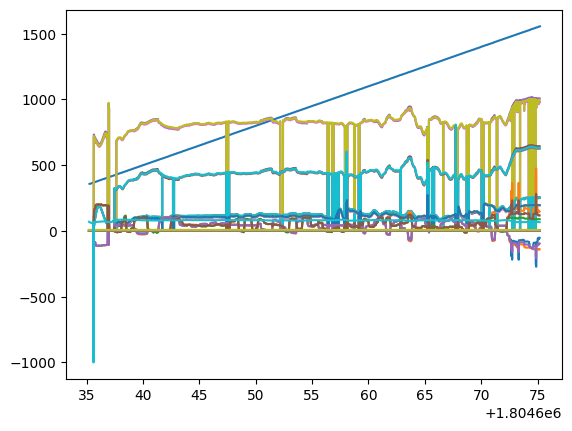

In [46]:
for stream in data:
    y = stream['time_series']

    if isinstance(y, list):
        # list of strings, draw one vertical line for each marker
        for timestamp, marker in zip(stream['time_stamps'], y):
            plt.axvline(x=timestamp)
            print(f'Marker "{"".join(marker)}" @ {timestamp:.2f}s')
    elif isinstance(y, np.ndarray):
        # numeric data, draw as lines
        plt.plot(stream['time_stamps'], y)
    else:
        raise RuntimeError('Unknown stream format')

plt.show()

Wow that is a lot of (messy) data, let's tease this apart one-by-one. 
Start with identifying which types of data are in the streams, this type is specifyied in the ["info"] part of the data.
The code below finds the correct index for different types of data (e.g., eye-tracking, GSR, Event Markers, or Webcam data).
If a type of data is not present in the data, the index will remain 99

In [49]:
#find the correct index of the different data types and store answer in dict
data_index = {
"Eye": 99,
"GSR": 99,
"Webcam": 99,
"Markers":99
}

i = 0
for stream in data:
    data_type = stream["info"]["type"][0]
    if data_type == "Gaze":
            data_index["Eye"] = i
    elif data_type == "GSR":
            data_index["GSR"] = i
    elif data_type == "videostream":
            data_index["Webcam"] = i
    elif data_type == "Markers":
            data_index["Markers"] = i
    i = i + 1

print(data_index)

{'Eye': 1, 'GSR': 99, 'Webcam': 0, 'Markers': 99}


The output shows that the data contains eye-tracking data ('Eye') in stream number 1, and Webcam data in stream number 0.
Different types of data can be selected by specifying the data_index like below.
Let's start by looking at the eye-tracking data, and we'll look at the webcam data later. 

The part below prints one sample of eye-tracking data, which contains 29 channels of information. This is a lot of information, but not all 29 channels are important to look at and some are duplicates (e.g., left and right eye, and gaze positions in pixels or percentages). 
The most important and useful variables are gaze positions (X, Y coordinates) and pupil size (in millimiters). 
Some other variables that might be interesting are the participant's distance from the screen and whether both eyes were visible. 
You can run the code and scroll through all the channels below to see their descriptions and units. 


In [56]:
np.size(data[data_index["Eye"]]["time_series"][0]) #29 channels of information
data[data_index["Eye"]]["info"]["desc"][0] #full list with info about all the 29 eyetracking streamed channels

defaultdict(list,
            {'acquisition': [defaultdict(list,
                          {'manufacturer': ['EyeTechDS'],
                           'model': ['VT3-Mini'],
                           'application': ['LSL EyeTechDS']})],
             'channels': [defaultdict(list,
                          {'channel': [defaultdict(list,
                                        {'label': ['LeftEye_Found'],
                                         'eye': ['left'],
                                         'unit': ['normalized'],
                                         'type': ['Confidence']}),
                            defaultdict(list,
                                        {'label': ['LeftEye_Calibrated'],
                                         'eye': ['left'],
                                         'unit': ['normalized'],
                                         'type': ['Confidence']}),
                            defaultdict(list,
                                        {'label

Let's focus on the gaze points for now

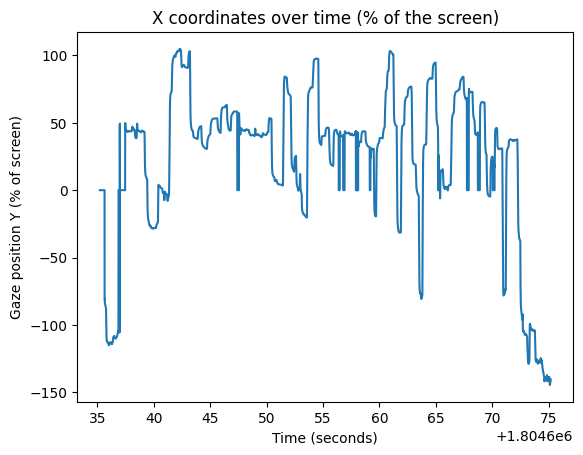

In [82]:
#show x and y coordinates together over time
plt.plot(data[data_index["Eye"]]["time_stamps"],data[data_index["Eye"]]["time_series"][:,20]) #Right eye gaze point channel (x coordinate in percentage points)
plt.xlabel("Time (seconds)")
plt.ylabel("Gaze position Y (% of screen)")
plt.title("X coordinates over time (% of the screen)")
plt.show() #some missing data, units should make sense between 0 and 100% 

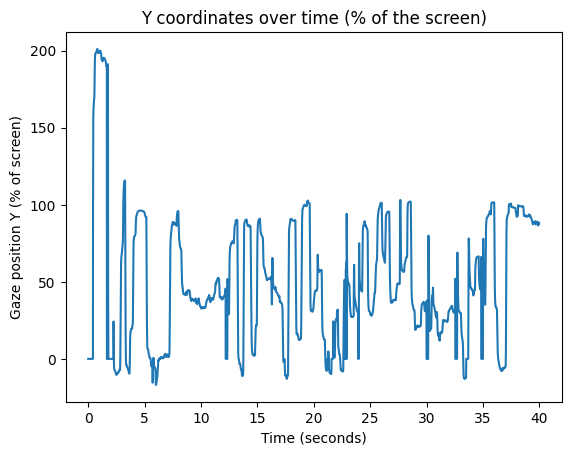

In [83]:
plt.plot(data[data_index["Eye"]]["time_stamps"]-data[data_index["Eye"]]["time_stamps"][0],data[data_index["Eye"]]["time_series"][:,21]) #Right eye gaze point channel (y coordinate in percentage points)
plt.xlabel("Time (seconds)")
plt.ylabel("Gaze position Y (% of screen)")
plt.title("Y coordinates over time (% of the screen)")
plt.show() #some missing data, units should make sense between 0 (top) and 100% (bottom)

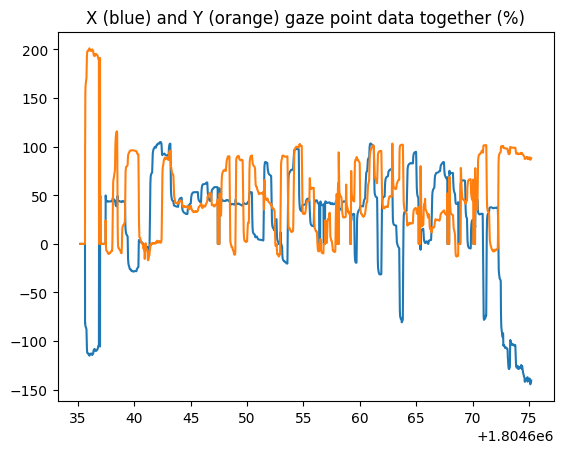

In [85]:
#show x and y coordinates together over time
plt.plot(data[data_index["Eye"]]["time_stamps"],data[data_index["Eye"]]["time_series"][:,20]) #Right eye gaze point channel (x coordinate in percentage points)
plt.plot(data[data_index["Eye"]]["time_stamps"],data[data_index["Eye"]]["time_series"][:,21]) #Right eye gaze point channel (y coordinate in percentage points)
plt.title("X (blue) and Y (orange) gaze point data together (%)")
plt.show() #some missing data, units should make sense between 0 (top) and 100% (bottom)

Now, show the all the gaze points (X and Y coordinates) that were measured in one figure

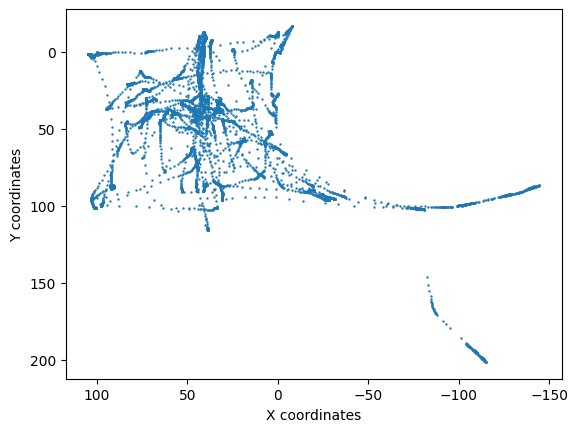

In [91]:
plt.scatter(data[data_index["Eye"]]["time_series"][:,20],data[data_index["Eye"]]["time_series"][:,21], 0.5) #X and Y points
plt.xlabel("X coordinates")
plt.ylabel("Y coordinates")

#origin is (0,0), which is the top-left of the screen (confusing), so invert y and x scales
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

Next to gaze points, you can get other information from eye-tracking data.
One of the most interesting variables in pupil size, which is related to someone level of arousal,
The pupil dilates when someone is aroused (e.g., stress or excitement), but it can also be influenced by lighting conditions. 
The code below shows an example of pupil size data over time

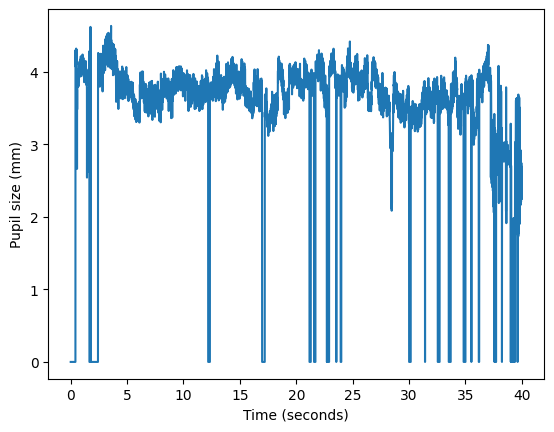

In [61]:
plt.plot(data[data_index["Eye"]]["time_stamps"]-data[data_index["Eye"]]["time_stamps"][0],data[data_index["Eye"]]["time_series"][:,2]) #left eye pupil size channel (diameter in millimeters)
plt.xlabel("Time (seconds)")
plt.ylabel("Pupil size (mm)")
plt.show() #some missing data (e.g., eye blinks), needs cleaning/preprocessing

As you can see, the data is somewhat messy and contains missing data, artifacts etc.
This is due to the nature of biometric data, when people blink for instance the eye-tracking cannot measure their eyes for a short moment.
Some preprocessing is necessary to clean the data and remove noise

In [ ]:
#remove or interpolate missing data

Start with combining the facereader data to the eye-tracking dataset.
Only for this type of data, the facial expressions are not included in the XDF file. 
Instead there are frame numbers in the XDF file, and a seperate file with the facial expression metrics. 
You should merge the datasets such that the metrics per frame correspond to the correct point in time. 
The code below shows how to do that

In [ ]:
#add column with frame numbers, going from 0 to the number of rows

#match the frame numbers in .xdf file to the output


Make figures and do some preliminary analyses

In [7]:
#plot the data

#estimate fixations

You should consider upgrading via the 'c:\users\p70071959\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


Let's load a different dataset that contains event markers, GSR data, and eye-tracking

In [62]:
#Load the .xdf file containing eye-tracking data and video frame numbers from github
url = 'https://github.com/sammy-w/bio_workshop/raw/main/p1.xdf'
r = requests.get(url)
print(r)

#write data to a file on the local jupyter notebook server
with open('p1.xdf', 'wb') as file:
    file.write(r.content)

#load data using pyxdf library
p1_data, header = pyxdf.load_xdf('p1.xdf')

<Response [200]>


Stream 3: Calculated effective sampling rate 197.9312 Hz is different from specified rate 60.0000 Hz.


Marker "00" @ 703879.83s
Marker "02" @ 703883.90s
Marker "99" @ 703895.99s
Marker "" @ 703904.15s


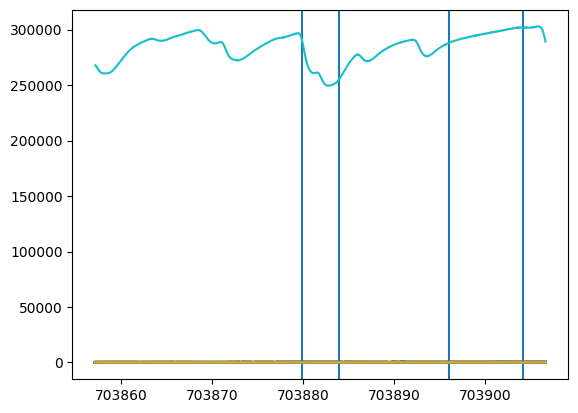

In [63]:
for stream in p1_data:
    y = stream['time_series']

    if isinstance(y, list):
        # list of strings, draw one vertical line for each marker
        for timestamp, marker in zip(stream['time_stamps'], y):
            plt.axvline(x=timestamp)
            print(f'Marker "{"".join(marker)}" @ {timestamp:.2f}s')
    elif isinstance(y, np.ndarray):
        # numeric data, draw as lines
        plt.plot(stream['time_stamps'], y)
    else:
        raise RuntimeError('Unknown stream format')

plt.show()